# Tales of Tribute Deck Suggestions

#### Import modules

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations

import matplotlib.pyplot as plt

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

## Import data

In [2]:
# import ToT match details from google sheets

gc = gspread.service_account()

# name of file in Google Sheets
sh = gc.open('Tales of Tribute')

# name of sheet in file
df = get_as_dataframe(sh.worksheet('matches'))

In [3]:
df.head(5)

,choice,opponent,p1 first,p2 first,p2 second,p1 second,result,notes
0,2.0,miribeans,black,red,green,blue,W,NaN
1,1.0,Kovuash,red,yellow,purple,green,W,NaN
2,2.0,Kovuash,red,green,black,purple,L,NaN
3,1.0,Kovuash,green,red,purple,yellow,W,NaN
4,1.0,RagedAvenger,green,blue,yellow,red,W,great cards


## Clean data

###### Functions


In [4]:
# sort decks in string alphabetically
def sort_decks(chosen_decks):

	# convert string to lowercase
	decks = chosen_decks.lower()
	# split string into individual decks
	decks = decks.split()

	# sort decks alphabetically
	decks.sort()

	# create empty string
	combined = ''

	for deck in range(len(decks)):
		combined = combined + decks[deck] + ' '

	# remove extra space at the end
	combined = combined.strip()
	return combined

In [5]:
# remove any rows with missing match info
df = df.dropna(subset=['p1 first', 'p2 first', 'p2 second', 'p1 second', 'result'])

# reset index
df.reset_index(inplace=True, drop=True)

# convert choice order column to integers
df['choice'] = df['choice'].apply(int)

# replace nan in notes column with empty strings
df['notes'] = df['notes'].replace(np.nan, '', regex=True)

In [6]:
# remove whitespace from decks + results & convert to lowercase
for col in df[['p1 first', 'p2 first', 'p2 second', 'p1 second', 'result']]:
    df[col] = df[col].str.strip().str.lower()

# remove whitespace from opponent names
df['opponent'] = df['opponent'].str.strip()

###### Replace deck names

In [7]:
# dictionary of current deck names & replacements
deck_names = {
    'black':'reach', 
    'blue':'psijic', 
    'green':'hunding', 
    'orange':'rajhin', 
    'orgnum':'orgnum', 
    'purple':'crow', 
    'red':'pelin', 
    'yellow':'hlaalu', 
    'druid':'druid'
    }

# replace deck names from spreadsheet with proper deck names
df = df.replace(deck_names)

# ADD CHECK FOR ANY DECK NAMES THAT AREN'T IN DICT?

In [8]:
df.head(5)

,choice,opponent,p1 first,p2 first,p2 second,p1 second,result,notes
0,2,miribeans,reach,pelin,hunding,psijic,w,
1,1,Kovuash,pelin,hlaalu,crow,hunding,w,
2,2,Kovuash,pelin,hunding,reach,crow,l,
3,1,Kovuash,hunding,pelin,crow,hlaalu,w,
4,1,RagedAvenger,hunding,psijic,hlaalu,pelin,w,great cards


###### Convert result column for calculating scores

In [9]:
# check unique values from the 'result' col
df.result.unique()

array(['w', 'l', 'c', 'dc'], dtype=object)

In [10]:
# match record values used
# results column values in df
win = 'w'
loss = 'l'
concede = 'c' # optional

# create new columns to hold number values for results of each match
df['won'] = 0
df['lost'] = 0

# split results column into either won or lost col
df.loc[df['result'] == win, 'won'] = 1
df.loc[df['result'] == loss, 'lost'] = 1
df.loc[df['result'] == concede, 'lost'] = 1

In [11]:
# check rows where neither 'won' or 'lost' were changed to 1
display(df[df['won'] + df['lost'] < 1])

,choice,opponent,p1 first,p2 first,p2 second,p1 second,result,notes,won,lost
49,1,qkslzodla,hunding,orgnum,crow,hlaalu,dc,internet went out,0,0
51,1,aestrivex,hunding,psijic,rajhin,hlaalu,dc,internet went out,0,0
325,2,Slick-Fox,crow,hunding,hlaalu,reach,dc,fml,0,0
400,1,NordCarbon,pelin,rajhin,psijic,hlaalu,dc,disconnected,0,0
586,1,deejaypalmer,pelin,rajhin,hlaalu,crow,dc,"fuck trains, I was winning.",0,0


###### Group match results by selected decks

In [12]:
df['decks'] = (
    df['p1 first']
    + ' '
    + df['p2 first']
    + ' '
    + df['p2 second']
    + ' '
    + df['p1 second']
)

# sort chosen decks values alphabetically
for match, decks in enumerate(df['decks']):
    df.at[match, 'decks'] = sort_decks(decks)

In [13]:
df.head(5)

,choice,opponent,p1 first,p2 first,p2 second,p1 second,result,notes,won,lost,decks
0,2,miribeans,reach,pelin,hunding,psijic,w,,1,0,hunding pelin psijic reach
1,1,Kovuash,pelin,hlaalu,crow,hunding,w,,1,0,crow hlaalu hunding pelin
2,2,Kovuash,pelin,hunding,reach,crow,l,,0,1,crow hunding pelin reach
3,1,Kovuash,hunding,pelin,crow,hlaalu,w,,1,0,crow hlaalu hunding pelin
4,1,RagedAvenger,hunding,psijic,hlaalu,pelin,w,great cards,1,0,hlaalu hunding pelin psijic


## Deck combination scores

In [14]:
def get_scores(df):
    df_scores = pd.concat((df.groupby('decks')['won'].sum(), df.groupby('decks')['lost'].sum()), axis=1)

    # create column of total matches per deck combination
    df_scores['total'] = df_scores['won'] + df_scores['lost']

    # create column of % of matches that are wins per unique combination
    df_scores['% wins'] = ((df_scores['won'] / df_scores['total']) * 100).round(decimals=1)

    return df_scores

In [15]:
scores = get_scores(df)

In [16]:
scores.head(5)

,won,lost,total,% wins
decks,,,,
crow druid hlaalu psijic,2,1,3,66.7
crow druid hlaalu reach,1,0,1,100.0
crow druid orgnum psijic,1,0,1,100.0
crow hlaalu hunding orgnum,8,2,10,80.0
crow hlaalu hunding pelin,43,18,61,70.5


###### Create dataframe of all possible deck combinations

In [17]:
# create list of all decks from deck_names values
all_decks = list(deck_names.values())

# create list of all unique combinations of 4 decks
combos = [' '.join(map(str, combo)) for combo in combinations(all_decks, 4)]

# convert list to dataframe
combos = pd.DataFrame(combos, columns=['decks'])

In [18]:
# sort chosen decks values alphabetically
for match, decks in enumerate(combos['decks']):
    combos.at[match, 'decks'] = sort_decks(decks)

# sort dataframe by 'decks' values, alphabetically
combos = combos.sort_values('decks')

###### Merge all combinations with match scores

In [19]:
# left merge scores dataframe onto combos
combos = combos.merge(
    scores, how='left', left_on='decks', right_index=True
)

# fill any blanks from unused combinations with 0s or blanks
combos.fillna({'won': 0, 'lost': 0, 'total': 0}, inplace=True)

In [20]:
combos.head(5)

,decks,won,lost,total,% wins
109,crow druid hlaalu hunding,0.0,0.0,0.0,NaN
123,crow druid hlaalu orgnum,0.0,0.0,0.0,NaN
125,crow druid hlaalu pelin,0.0,0.0,0.0,NaN
89,crow druid hlaalu psijic,2.0,1.0,3.0,66.7
119,crow druid hlaalu rajhin,0.0,0.0,0.0,NaN


In [21]:
combos_sh = combos.copy()

for row, decks in enumerate(combos_sh['decks']):
    deck_list = decks.split()
    combos_sh.at[row, 'a'] = deck_list[0]
    combos_sh.at[row, 'b'] = deck_list[1]
    combos_sh.at[row, 'c'] = deck_list[2]
    combos_sh.at[row, 'd'] = deck_list[3]

In [22]:
combos_sh = combos_sh[['a', 'b', 'c', 'd', 'won', 'lost', 'total', '% wins', 'decks']]
combos_sh.head(10)

,a,b,c,d,won,lost,total,% wins,decks
109,hlaalu,pelin,rajhin,reach,0.0,0.0,0.0,NaN,crow druid hlaalu hunding
123,orgnum,pelin,rajhin,reach,0.0,0.0,0.0,NaN,crow druid hlaalu orgnum
125,pelin,psijic,rajhin,reach,0.0,0.0,0.0,NaN,crow druid hlaalu pelin
89,druid,pelin,rajhin,reach,2.0,1.0,3.0,66.7,crow druid hlaalu psijic
119,hunding,pelin,rajhin,reach,0.0,0.0,0.0,NaN,crow druid hlaalu rajhin
54,crow,pelin,rajhin,reach,1.0,0.0,1.0,100.0,crow druid hlaalu reach
103,hlaalu,orgnum,pelin,reach,0.0,0.0,0.0,NaN,crow druid hunding orgnum
108,hlaalu,pelin,psijic,reach,0.0,0.0,0.0,NaN,crow druid hunding pelin
67,druid,hlaalu,pelin,reach,0.0,0.0,0.0,NaN,crow druid hunding psijic
97,hlaalu,hunding,pelin,reach,0.0,0.0,0.0,NaN,crow druid hunding rajhin


###### Individual deck performance

In [23]:
# find success rates for matches with each individual deck

single_decks = pd.DataFrame()

for deck in all_decks:
    # find all deck combinations containing an individual deck
    filtered = combos[combos['decks'].str.contains(deck, na=False)]

    # find the mean success rate with combinations including that deck
    single_decks.at[deck, '% wins'] = filtered['% wins'].mean()
    single_decks['% wins'] = single_decks['% wins'].round(decimals=2)

    # find total number of matches with deck
    single_decks.at[deck, 'matches'] = filtered['total'].sum()

In [24]:
# create separate column for deck name
single_decks.reset_index(inplace=True)
single_decks = single_decks.rename(columns={'index':'deck'})

In [25]:
# decks sorted chromatically
sorter = ['pelin', 'rajhin', 'hlaalu', 'druid', 'hunding', 'orgnum', 'psijic', 'crow', 'reach']

# convert deck column to category type using sorter list
single_decks.deck = single_decks.deck.astype('category')
single_decks.deck = single_decks.deck.cat.set_categories(sorter)

# sort df
single_decks = single_decks.sort_values('deck', ascending=False)

In [26]:
single_decks.head(5)

,deck,% wins,matches
0,reach,60.40,401.0
5,crow,54.92,283.0
1,psijic,53.38,159.0
4,orgnum,57.66,61.0
2,hunding,60.96,408.0


In [27]:
# deck colors
plot_colors = {
    'pelin': '#7C211D',
    'rajhin': '#B54824',
    'hlaalu': '#E29836',
    'druid': '#A7BC31',
    'hunding': '#417238',
    'orgnum': '#51B2BC',
    'psijic': '#4C6BB5',
    'crow': '#5D3291',
    'reach': '#33302F'
    }

# value at end of each bar
bar_text = {'va':'center', 'ha':'right', 'size':10}

plt.style.use("seaborn")

###### Functions

In [28]:
# use plot_colors dict for cell background in dataframe
def color_chart(deck):
    if deck in all_decks:
        color = plot_colors[deck]
        return 'background-color: %s' % color
        

# adjust dataframe formatting
def shade_cells(dataframe):
    return dataframe.style.applymap(color_chart).set_properties(**{'text-align':'center'}).format(precision=0, na_rep='n/a')

In [29]:
def filter_combos(df, *decks):

    filtered = df.copy()

    for deck in decks:
        if deck not in deck_names.values() and deck in deck_names:
            deck = deck_names[deck]

        # find combinations containing selected decks
        filtered = filtered[filtered['decks'].str.contains(deck, na=False)]
        filtered.replace(deck, '', inplace=True, regex=True)
    
    filtered['decks'] = filtered['decks'].str.strip()

    # remove combinations that haven't been used yet (NaN in % wins col)
    filtered = filtered.dropna()

    # reset index
    filtered.reset_index(inplace=True, drop=True)
    return filtered

In [39]:
# create a graph of deck choices
def choice_graph(x, y, color, title):
    
    # adjust graph size based on number of decks to choose from
    graph_length = (len(x) / 4) + 2
    
    fig, ax =plt.subplots(figsize=(6,graph_length), dpi=100)

    ax.set_title(title)
    ax.barh(x, y, color=color, alpha=0.82)
    ax.set_xlim(-10, None)

    for index, value in enumerate(y):
        plt.text((value - 2), (index-0.05), str('{:.0f}%'.format(value)), **bar_text)

    #fig.savefig("images/example.jpg", bbox_inches="tight")

##### Deck combinations x3

In [31]:
p2_choices = [' '.join(map(str, combo)) for combo in combinations(all_decks, 3)]

p2_choices = pd.DataFrame(p2_choices, columns=['decks'])

In [32]:
def choose_deck(*chosen_decks):

    chosen_decks = [i for i in chosen_decks if i]

    # if three decks were entered, return choices for final deck
    if len(chosen_decks) == 3:
        
        choices = combos.copy()

        for chosen_deck in chosen_decks:
            choices = filter_combos(choices, chosen_deck)

        x = choices['decks']
        y = choices['% wins']
        colors = [plot_colors[key] for key in x]
        title = f'tales of tribute: final choice ({chosen_decks[0]}, {chosen_decks[1]}, {chosen_decks[2]})'

    # if one deck was entered, find best choices for second and third decks
    elif len(chosen_decks) == 1:

        choices = filter_combos(p2_choices, chosen_decks[0])

        for row, deck_pairs in enumerate(choices['decks']):
            deck_pairs = deck_pairs.split()

            choices_score = filter_combos(combos, chosen_decks[0], deck_pairs[0], deck_pairs[1])

            untested = (6 - len(choices_score.index))

            score = choices_score['% wins'].sum()

            choices.at[row, 'untested'] = untested

            if untested == 6:
                choices.at[row, '% wins'] = 0

            elif score == 0:
                choices.at[row, '% wins'] = 0

            else:
                choices.at[row, '% wins'] = (score / (6 - untested)).round(decimals=1)

        choices = choices.sort_values(['untested','% wins'], ascending=[True, False])
        choices = choices.head(10)

        x = choices['decks']
        y = choices['% wins']
        if chosen_decks[0] not in plot_colors and chosen_decks[0] in deck_names:
            colors = plot_colors[deck_names[chosen_decks[0]]]
        else:
            colors = plot_colors[chosen_decks[0]]
        title = f'tales of tribute: player 2 deck choices ({chosen_decks[0]})'

    # if no decks were entered, show performance of individual decks
    else:
        
        x = single_decks['deck']
        y = single_decks['% wins']
        colors = [plot_colors[key] for key in x]
        title = 'tales of tribute: first deck choice'

    choice_graph(x, y, colors, title)

## Opponent deck choices

In [33]:
# create new columns
df["op deck 1"] = ""
df["op deck 2"] = ""

# fill new columns based on choice order
for i, value in enumerate(df["choice"]):
    if value == 1:
        # fill new cols for matches as player 1
        df.at[i, "op deck 1"] = df.at[i, "p2 first"]
        df.at[i, "op deck 2"] = df.at[i, "p2 second"]

    elif value == 2:
        # fill new cols for matches as player 2
        df.at[i, "op deck 1"] = df.at[i, "p1 first"]
        df.at[i, "op deck 2"] = df.at[i, "p1 second"]

In [34]:
# filter dataframe for opposing player sheet
players = df[
    [
        "opponent",
        "op deck 1",
        "op deck 2",
        "won",
        "lost",
        "notes",
    ]
]

# sort matches by opponent username
players = players.sort_values(by="opponent", key=lambda col: col.str.lower())

# reset index
players.reset_index(drop=True, inplace=True)

In [35]:
players.head(3)

,opponent,op deck 1,op deck 2,won,lost,notes
0,(forgot to write down),crow,pelin,0,1,cards betrayed me literally at the end
1,(forgot to write down),crow,reach,1,0,
2,"(player, forgot to write)",pelin,hlaalu,0,1,cards were against me


In [36]:
# set worksheet to save players to
worksheet = sh.worksheet("players")

# save worksheet to Google Sheets
set_with_dataframe(worksheet, players)
print("players worksheet updated")

players worksheet updated


## Examples

#### Example 1:

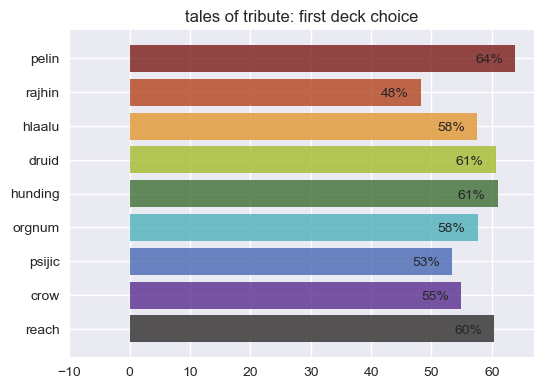

In [41]:
# player 1, first deck
choose_deck()

In [ ]:
# player 1, fourth deck
choose_deck('red', 'black', 'purple')

#### Example 2:

In [ ]:
# player 2, second and third decks
choose_deck('yellow')

#### Example 3:

In [ ]:
# player 1, fourth deck
choose_deck('red', 'yellow', 'purple')

## Match Suggestion

In [ ]:
deck1 = 'black'
deck2 = 'red'
deck3 = 'yellow'

choose_deck(deck1, deck2, deck3)

In [ ]:
opponent = "Eliaticstranger"
opp_prefs = players[players["opponent"] == opponent]

opp_prefs[['opponent', 'op deck 1', 'op deck 2']].style.applymap(color_chart)

###### Copy & paste for match record:

In [ ]:
print(opponent, deck1, deck2, deck3, sep=',')